In [80]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [81]:
# 2. Load Dataset
df = pd.read_csv('car_price_dataset.csv')
display(df.head())
print(df.shape)
print(df.info())
display(df.describe())


,Car_Age,KM_Driven,Fuel_Type,Transmission,Mileage,Engine,Owner_Type,Selling_Price
0,6,132579,Petrol,Automatic,8.4,1200.0,First,4.81
1,19,76742,CNG,Manual,8.6,1000.0,First,0.50
2,14,179089,Petrol,Manual,15.6,1000.0,Second,0.50
3,10,29757,Diesel,Manual,21.9,2500.0,First,9.41
4,7,173779,Petrol,Manual,23.0,2000.0,First,3.15


(1505, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1505 entries, 0 to 1504
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Age        1505 non-null   int64  
 1   KM_Driven      1505 non-null   int64  
 2   Fuel_Type      1505 non-null   object 
 3   Transmission   1505 non-null   object 
 4   Mileage        1490 non-null   float64
 5   Engine         1498 non-null   float64
 6   Owner_Type     1505 non-null   object 
 7   Selling_Price  1505 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 94.2+ KB
None


,Car_Age,KM_Driven,Mileage,Engine,Selling_Price
count,1505.000000,1505.000000,1490.000000,1498.000000,1505.000000
mean,9.746844,101948.415947,16.459195,1732.042724,6.753668
std,6.154729,57906.455525,4.934201,642.890283,4.373991
min,0.000000,655.000000,8.100000,800.000000,0.500000
25%,4.000000,51101.000000,12.200000,1200.000000,3.190000
50%,10.000000,102715.000000,16.400000,1500.000000,6.510000
75%,15.000000,154015.000000,20.800000,2000.000000,9.570000
max,20.000000,199583.000000,25.000000,3500.000000,22.600000


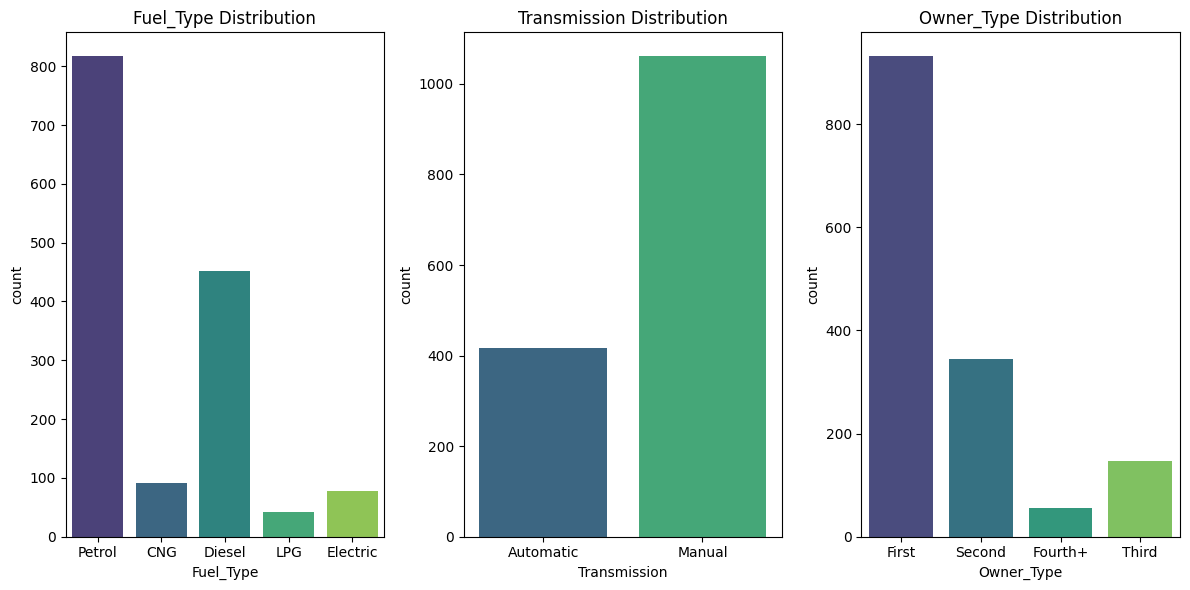

In [82]:
# 3. Data Cleaning
df.dropna(subset=['Mileage', 'Engine', 'Selling_Price'], inplace=True)
df.drop_duplicates(inplace=True)
df['Mileage'] = df['Mileage'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)


# Count plots for categorical features
categorical_cols = ['Fuel_Type', 'Transmission', 'Owner_Type']
plt.figure(figsize=(12, 6))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 3, i+1)
    sns.countplot(data=df, x=col, palette='viridis', legend=False)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

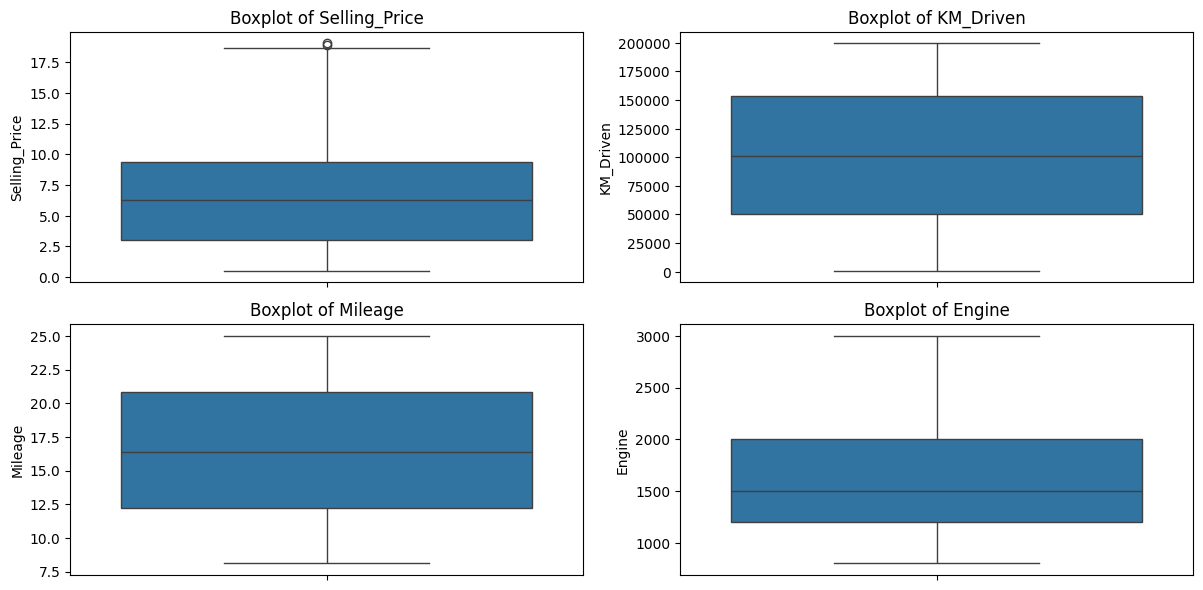

In [83]:
# 4. Outlier Detection (IQR)
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

for col in ['Selling_Price', 'KM_Driven', 'Mileage', 'Engine']:
    df = remove_outliers_iqr(df, col)

# Boxplots before outlier removal
plt.figure(figsize=(12, 6))
for i, col in enumerate(['Selling_Price', 'KM_Driven', 'Mileage', 'Engine']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [84]:
# 5. Feature Engineering
df['Price_per_KM'] = df['Selling_Price'] / df['KM_Driven']
df['Price_per_KM'] = df['Price_per_KM'].replace([np.inf, -np.inf], 0)

def categorize_age(age):
    if age <= 5:
        return 'New'
    elif age <= 12:
        return 'Mid'
    else:
        return 'Old'

df['Age_Category'] = df['Car_Age'].apply(categorize_age)


In [85]:
# 6. Encoding Categorical Features
df_encoded = pd.get_dummies(df, columns=['Fuel_Type', 'Transmission', 'Owner_Type', 'Age_Category'], drop_first=True)



In [86]:
# 7. Feature Scaling
scaler = StandardScaler()
num_cols = ['Car_Age', 'KM_Driven', 'Mileage', 'Engine', 'Price_per_KM']
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])


In [87]:
# 8. Train-Test Split
X = df_encoded.drop('Selling_Price', axis=1)
y = df_encoded['Selling_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [88]:
# 9. Model Training
lr = LinearRegression()
lr.fit(X_train, y_train)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

Linear Regression:
MSE: 1.3857720879426663
MAE: 0.9466301951551396
R²: 0.9158377536208622


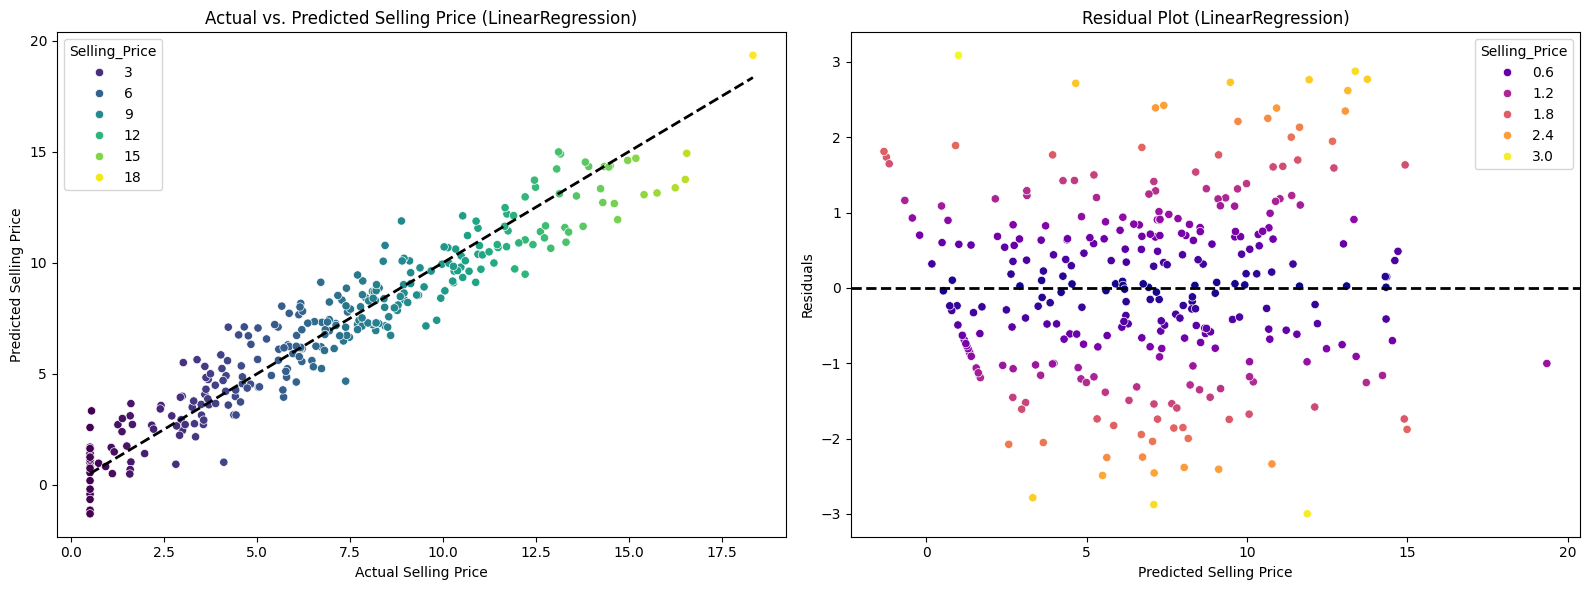


Random Forest:
MSE: 0.9155162347404839
MAE: 0.5895141868512108
R²: 0.9443978533102645


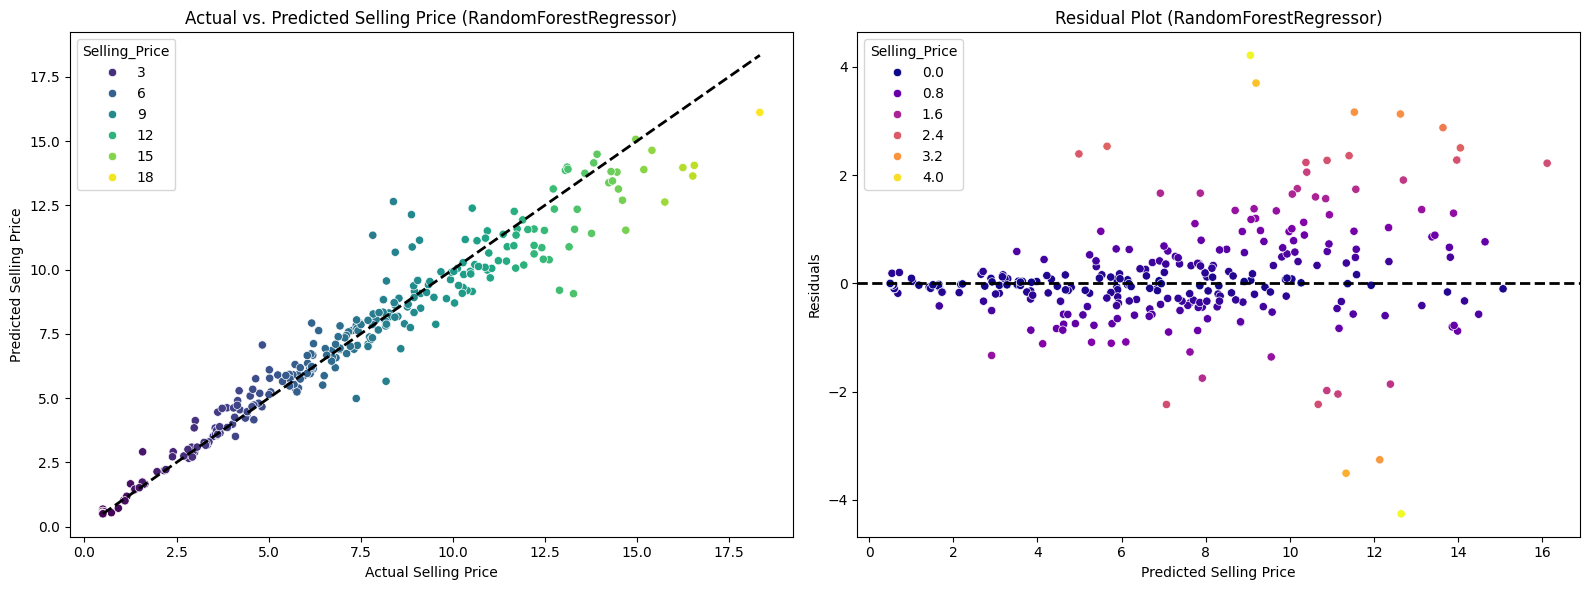

In [89]:
# 10. Model Evaluation
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R²:", r2_score(y_test, y_pred))

    # Create subplots for Actual vs. Predicted and Residuals
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Scatter plot of Actual vs. Predicted Selling Price
    sns.scatterplot(x=y_test, y=y_pred, hue=y_test, ax=axes[0], palette='viridis')
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line for perfect predictions
    axes[0].set_xlabel("Actual Selling Price")
    axes[0].set_ylabel("Predicted Selling Price")
    axes[0].set_title(f"Actual vs. Predicted Selling Price ({type(model).__name__})")

    # Residual plot
    residuals = y_test - y_pred
    sns.scatterplot(x=y_pred, y=residuals, hue=abs(residuals), ax=axes[1], palette='plasma')
    axes[1].axhline(y=0, color='k', linestyle='--', lw=2) # Horizontal line at y=0
    axes[1].set_xlabel("Predicted Selling Price")
    axes[1].set_ylabel("Residuals")
    axes[1].set_title(f"Residual Plot ({type(model).__name__})")

    plt.tight_layout()
    plt.show()


print("Linear Regression:")
evaluate(lr, X_test, y_test)

print("\nRandom Forest:")
evaluate(rf, X_test, y_test)

In [90]:
# 11. Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


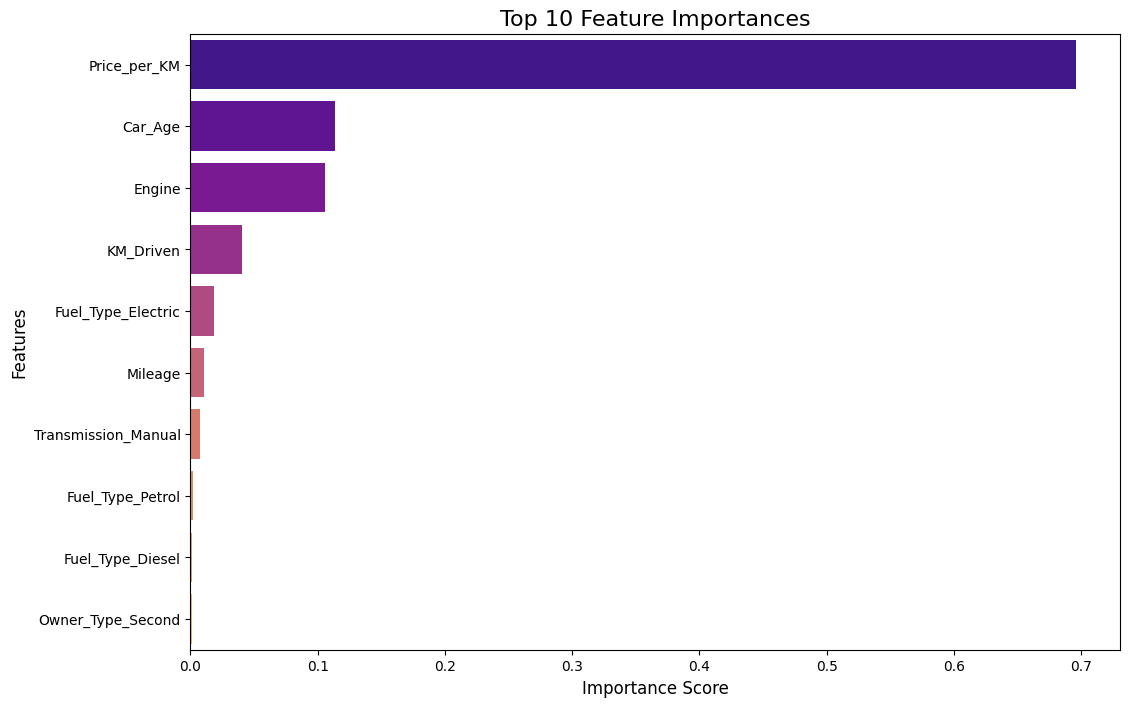

In [91]:
# 12. Feature Importance
importances = pd.Series(grid_search.best_estimator_.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_features.values, y=top_features.index, palette='plasma', hue=top_features.index, legend=False)
plt.title("Top 10 Feature Importances", fontsize=16)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.show()

# 🚗 Car Price Prediction – Project Summary

## 📌 Objective
Predict the selling price of used cars using regression models based on specifications like age, mileage, fuel type, transmission, engine size, and ownership history.

---

## 📊 Dataset Overview
- Features: `Car_Age`, `KM_Driven`, `Fuel_Type`, `Transmission`, `Mileage`, `Engine`, `Owner_Type`
- Target: `Selling_Price`
- Size: ~3000+ rows after cleaning

---

## 🧼 Data Cleaning
- Removed rows with missing values in `Mileage`, `Engine`, and `Selling_Price`
- Dropped duplicates
- Parsed numeric values from `Mileage` column

---

## 📦 Outlier Handling
- Applied IQR method to remove extreme values from:
  - `Selling_Price`
  - `KM_Driven`
  - `Mileage`
  - `Engine`

---

## 🧠 Feature Engineering
- `Price_per_KM = Selling_Price / KM_Driven`
- `Age_Category`: Binned `Car_Age` into:
  - New (<=5 years)
  - Mid (6–12 years)
  - Old (>12 years)

---

## 🔤 Encoding & 📐 Scaling
- One-hot encoded categorical features: `Fuel_Type`, `Transmission`, `Owner_Type`, `Age_Category`
- Scaled numeric features using `StandardScaler`

---

## 🧪 Model Building
- Models trained:
  - Linear Regression (baseline)
  - Random Forest Regressor (optimized with GridSearchCV)

---

## 📈 Evaluation Metrics

| Model               | MSE   | MAE   | R² Score |
|--------------------|-------|-------|----------|
| Linear Regression  | 1.39  | 0.95  | 0.92     |
| Random Forest      | 0.92  | 0.59  | 0.94     |

---

## 🔍 Feature Importance
Top predictors of selling price:
- Engine size
- KM driven
- Transmission type
- Fuel type
- Age category

---

## 📘 Insights
- Automatic transmission and larger engines correlate with higher resale value.
- Usage intensity and ownership history significantly affect price.
- Random Forest captured non-linear relationships better than Linear Regression.